<a href="https://colab.research.google.com/github/jjfj2011/Movie_Recommender_System/blob/main/Movie_Recommender_System_ML.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#**PROBLEMA DE NEGOCIO**


---




##Imagina tener acceso a los datos de una plataforma de streaming y usar esos datos para mejorar la experiencia del usuario. Como científicos de datos, analizarán estos datos con Python y construirán un recomendador de películas personalizado que ofrecerá sugerencias precisas y relevantes, revolucionando la forma en que los usuarios descubren nuevos contenidos.

### **Objetivos**

1. Recomendador no personalizado

2. Recomendador Content-based

3. Recomendador Collaborative filtering

#**1. Configuración del Ambiente**


---




In [ ]:
!python -V
print('------')
!pip show Pandas | grep 'Name\|Version'
print('------')
!pip show Matplotlib | grep 'Name\|Version'

Python 3.10.12
------
Name: pandas
Version: 2.1.4
------
Name: matplotlib
Version: 3.7.1


In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import seaborn as sns
import zipfile
import warnings
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.neighbors import NearestNeighbors
from sklearn.metrics import pairwise_distances
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics.pairwise import linear_kernel
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
pd.set_option('display.float_format', '{:.2f}'.format)
!curl http://files.grouplens.org/datasets/movielens/ml-latest-small.zip -o ml-latest-small.zip
with zipfile.ZipFile('ml-latest-small.zip', 'r') as zip_ref:
    zip_ref.extractall('data')
global df_movies, df_ratings, df_final

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  955k  100  955k    0     0  1916k      0 --:--:-- --:--:-- --:--:-- 1914k


#**2. Obtención, Tratamiento y Análisis Exploratório (EDA)**


---




##**2.1 Cargando las bases de datos**

In [ ]:
df_movies = pd.read_csv('data/ml-latest-small/movies.csv')
df_movies.head()

,movieId,title,genres
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,2,Jumanji (1995),Adventure|Children|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance
4,5,Father of the Bride Part II (1995),Comedy


In [ ]:
df_ratings = pd.read_csv('data/ml-latest-small/ratings.csv')
df_ratings.head()

,userId,movieId,rating,timestamp
0,1,1,4.00,964982703
1,1,3,4.00,964981247
2,1,6,4.00,964982224
3,1,47,5.00,964983815
4,1,50,5.00,964982931


##**2.2 Tratamiento de Datos**

In [ ]:
print(df_movies.info())
print('-------------')
print(df_ratings.info())
print('-------------')

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9742 entries, 0 to 9741
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   movieId  9742 non-null   int64 
 1   title    9742 non-null   object
 2   genres   9742 non-null   object
dtypes: int64(1), object(2)
memory usage: 228.5+ KB
None
-------------
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100836 entries, 0 to 100835
Data columns (total 4 columns):
 #   Column     Non-Null Count   Dtype  
---  ------     --------------   -----  
 0   userId     100836 non-null  int64  
 1   movieId    100836 non-null  int64  
 2   rating     100836 non-null  float64
 3   timestamp  100836 non-null  int64  
dtypes: float64(1), int64(3)
memory usage: 3.1 MB
None
-------------


In [ ]:
#@title
def preprocesamiento():
  # Variables globales
  global df_movies, df_ratings

  # Para ambos dataframe elimina los registros con alguna columna nula
  df_movies.dropna(inplace=True)
  df_ratings.dropna(inplace=True)

  # Elimina todos los registros duplicados en df_movies, considera la columna 'movieId' como llave
  df_movies.drop_duplicates(subset=['movieId'], inplace=True)

  # Elimina todos los registros duplicados en df_ratings, considera las columnas 'movieId','userId' como llaves
  df_ratings.drop_duplicates(subset=['movieId','userId'], inplace=True)

  # En df_movies puedes crear la columna 'content' a partir de la columna 'genres', apenas reemplazando '|' por ' ', usaremos esta nueva columna más adelante
  df_movies['content'] = df_movies['genres'].str.replace('|', ' ', regex=False)

  # En 'df_movies' puedes crear la columna 'genre_set' a partir de la columna 'genres', esta nueva columna es de tipo set y contiene todos los géneros separados por coma ','
  df_movies['genre_set'] = df_movies['genres'].apply(lambda x: set(x.split('|')))

  # Asegúrate de que todas las columnas, de cada uno de los 2 dataframe, tengan el tipo de datos correcto, números con into float, textos con object y fechas con datetime
  df_ratings['timestamp'] = pd.to_datetime(df_ratings['timestamp'], unit='s')

In [ ]:
preprocesamiento()
print(df_movies.info())
print('-------------')
print(df_ratings.info())
print('-------------')

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9742 entries, 0 to 9741
Data columns (total 5 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   movieId    9742 non-null   int64 
 1   title      9742 non-null   object
 2   genres     9742 non-null   object
 3   content    9742 non-null   object
 4   genre_set  9742 non-null   object
dtypes: int64(1), object(4)
memory usage: 380.7+ KB
None
-------------
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100836 entries, 0 to 100835
Data columns (total 4 columns):
 #   Column     Non-Null Count   Dtype         
---  ------     --------------   -----         
 0   userId     100836 non-null  int64         
 1   movieId    100836 non-null  int64         
 2   rating     100836 non-null  float64       
 3   timestamp  100836 non-null  datetime64[ns]
dtypes: datetime64[ns](1), float64(1), int64(2)
memory usage: 3.1 MB
None
-------------


In [ ]:
df_movies.head()

,movieId,title,genres,content,genre_set
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,Adventure Animation Children Comedy Fantasy,"{Animation, Children, Comedy, Adventure, Fantasy}"
1,2,Jumanji (1995),Adventure|Children|Fantasy,Adventure Children Fantasy,"{Children, Adventure, Fantasy}"
2,3,Grumpier Old Men (1995),Comedy|Romance,Comedy Romance,"{Romance, Comedy}"
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance,Comedy Drama Romance,"{Romance, Drama, Comedy}"
4,5,Father of the Bride Part II (1995),Comedy,Comedy,{Comedy}


In [ ]:
df_ratings.head()

,userId,movieId,rating,timestamp
0,1,1,4.00,2000-07-30 18:45:03
1,1,3,4.00,2000-07-30 18:20:47
2,1,6,4.00,2000-07-30 18:37:04
3,1,47,5.00,2000-07-30 19:03:35
4,1,50,5.00,2000-07-30 18:48:51


##**2.3 Análisis Exploratorio (EDA)**

In [ ]:
df_movies.head()

,movieId,title,genres,content,genre_set
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,Adventure Animation Children Comedy Fantasy,"{Animation, Children, Comedy, Adventure, Fantasy}"
1,2,Jumanji (1995),Adventure|Children|Fantasy,Adventure Children Fantasy,"{Children, Adventure, Fantasy}"
2,3,Grumpier Old Men (1995),Comedy|Romance,Comedy Romance,"{Romance, Comedy}"
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance,Comedy Drama Romance,"{Romance, Drama, Comedy}"
4,5,Father of the Bride Part II (1995),Comedy,Comedy,{Comedy}


In [ ]:
df_movies.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9742 entries, 0 to 9741
Data columns (total 5 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   movieId    9742 non-null   int64 
 1   title      9742 non-null   object
 2   genres     9742 non-null   object
 3   content    9742 non-null   object
 4   genre_set  9742 non-null   object
dtypes: int64(1), object(4)
memory usage: 380.7+ KB


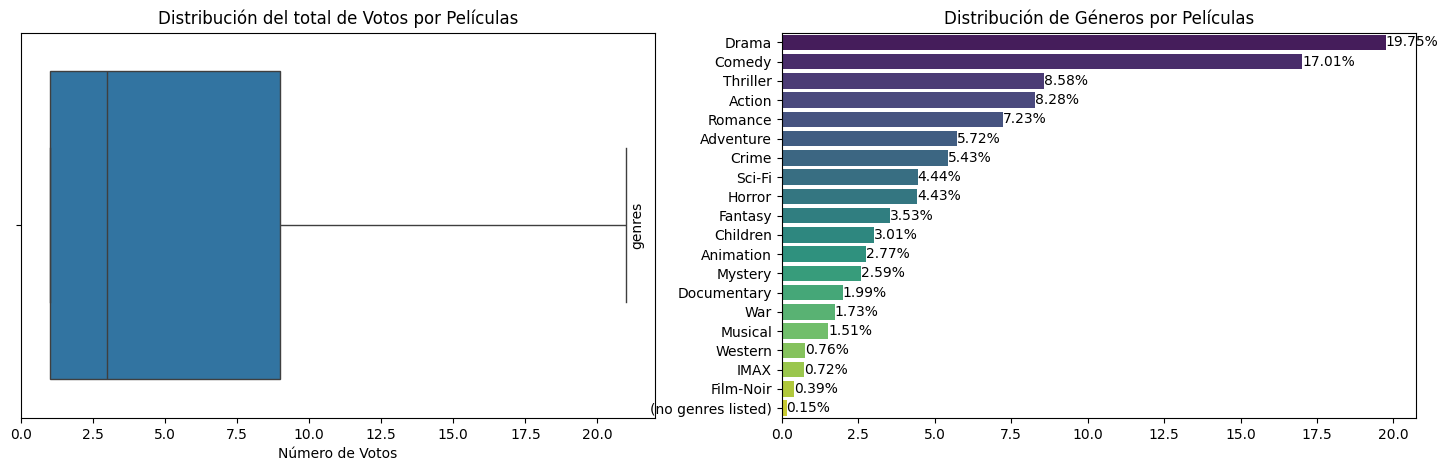

In [ ]:
fig,ax = plt.subplots(1,2,figsize=(18,5))

# PRIMER GRÁFICO
# Agrupar las calificaciones por 'movieId'
votes_per_movie = df_ratings.groupby('movieId').size().reset_index(name='total_votes')
# Ocultamos los outliers del boxplot actual
sns.boxplot(votes_per_movie['total_votes'], showfliers=False, orient='h', ax=ax[0])
ax[0].set_title('Distribución del total de Votos por Películas')
ax[0].set_xlabel('Número de Votos')


# SEGUNDO GRÁFICO
# Separamos los géneros en múltiples filas usando la columna 'genres'
df_movies_2 = df_movies.copy()
df_movies_2['genres'] = df_movies_2['genres'].str.split('|')
df_genres = df_movies_2.explode('genres')

genre_counts = df_genres['genres'].value_counts(normalize=True)
# genre_counts

# Creamos el gráfico de barras horizontales
sns.barplot(x=genre_counts.values * 100, y=genre_counts.index, hue=genre_counts.index, palette='viridis', ax=ax[1], dodge=False, legend=False)
ax[1].set_title('Distribución de Géneros por Películas')

# Agregamos los valores a la derecha de cada barra
for index,value in enumerate(genre_counts.values * 100):
  plt.text(value, index, f'{value:.2f}%', color='black', va='center')

plt.show()

In [ ]:
df_ratings.describe()

,userId,movieId,rating,timestamp
count,100836.00,100836.00,100836.00,100836
mean,326.13,19435.30,3.50,2008-03-19 17:01:27.368469248
min,1.00,1.00,0.50,1996-03-29 18:36:55
25%,177.00,1199.00,3.00,2002-04-18 09:57:46
50%,325.00,2991.00,3.50,2007-08-02 20:31:02
75%,477.00,8122.00,4.00,2015-07-04 07:15:44.500000
max,610.00,193609.00,5.00,2018-09-24 14:27:30
std,182.62,35530.99,1.04,NaN


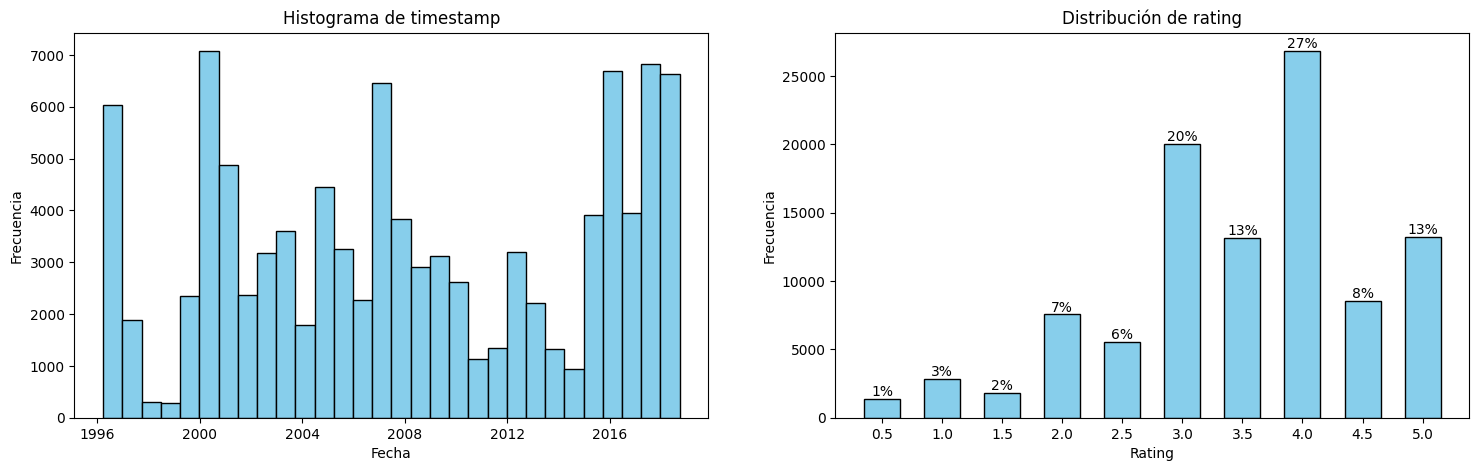

In [ ]:
fig,ax = plt.subplots(1, 2, figsize=(18,5))

# PRIMER GRÁFICO
ax[0].hist(df_ratings['timestamp'], bins=30, color='skyblue', edgecolor='black')
ax[0].set_title('Histograma de timestamp')
ax[0].set_xlabel('Fecha')
ax[0].set_ylabel('Frecuencia')


# SEGUNDO GRÁFICO
# Creamos la serie con los valores de 'rating' y su contador
rating_counts = df_ratings['rating'].value_counts().sort_index()
# Calculamos los porcentajes
total_counts = rating_counts.sum()
percentages = (rating_counts/total_counts) * 100

# Creamos el gráfico de barras
bar_width = 0.3 # Ancho de las barras
bars = ax[1].bar(rating_counts.index, rating_counts.values, color='skyblue', edgecolor='black', width=bar_width)

# Agregamos las etiquetas de los porcentajes
for bar in bars:
  height = bar.get_height()
  percentage = (height / total_counts) * 100
  plt.text(bar.get_x() + bar.get_width() / 2, height, f'{percentage:.0f}%', ha='center', va='bottom')

ax[1].set_title('Distribución de rating')
ax[1].set_xlabel('Rating')
ax[1].set_ylabel('Frecuencia')
plt.xticks(rating_counts.index) # Los valores de rating están en el eje X

plt.show()

In [ ]:
df_final = pd.merge(df_ratings, df_movies, on='movieId')
df_final.head()

,userId,movieId,rating,timestamp,title,genres,content,genre_set
0,1,1,4.00,2000-07-30 18:45:03,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,Adventure Animation Children Comedy Fantasy,"{Animation, Children, Comedy, Adventure, Fantasy}"
1,5,1,4.00,1996-11-08 06:36:02,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,Adventure Animation Children Comedy Fantasy,"{Animation, Children, Comedy, Adventure, Fantasy}"
2,7,1,4.50,2005-01-25 06:52:26,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,Adventure Animation Children Comedy Fantasy,"{Animation, Children, Comedy, Adventure, Fantasy}"
3,15,1,2.50,2017-11-13 12:59:30,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,Adventure Animation Children Comedy Fantasy,"{Animation, Children, Comedy, Adventure, Fantasy}"
4,17,1,4.50,2011-05-18 05:28:03,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,Adventure Animation Children Comedy Fantasy,"{Animation, Children, Comedy, Adventure, Fantasy}"


In [ ]:
df_final.describe()

,userId,movieId,rating,timestamp
count,100836.00,100836.00,100836.00,100836
mean,326.13,19435.30,3.50,2008-03-19 17:01:27.368469504
min,1.00,1.00,0.50,1996-03-29 18:36:55
25%,177.00,1199.00,3.00,2002-04-18 09:57:46
50%,325.00,2991.00,3.50,2007-08-02 20:31:02
75%,477.00,8122.00,4.00,2015-07-04 07:15:44.500000
max,610.00,193609.00,5.00,2018-09-24 14:27:30
std,182.62,35530.99,1.04,NaN


#**3. Estrategias de Recomendación**


---




##**3.1 Recomendación no personalizada**

In [ ]:
df_final.head()

,userId,movieId,rating,timestamp,title,genres,content,genre_set
0,1,1,4.00,2000-07-30 18:45:03,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,Adventure Animation Children Comedy Fantasy,"{Animation, Children, Comedy, Adventure, Fantasy}"
1,5,1,4.00,1996-11-08 06:36:02,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,Adventure Animation Children Comedy Fantasy,"{Animation, Children, Comedy, Adventure, Fantasy}"
2,7,1,4.50,2005-01-25 06:52:26,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,Adventure Animation Children Comedy Fantasy,"{Animation, Children, Comedy, Adventure, Fantasy}"
3,15,1,2.50,2017-11-13 12:59:30,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,Adventure Animation Children Comedy Fantasy,"{Animation, Children, Comedy, Adventure, Fantasy}"
4,17,1,4.50,2011-05-18 05:28:03,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,Adventure Animation Children Comedy Fantasy,"{Animation, Children, Comedy, Adventure, Fantasy}"


In [ ]:
#@title
def recomendacion_populares():
  global df_movies, df_ratings, df_final

  # Calcula cuantas veces cada película ha sido votada
  item_counts = df_final['title'].value_counts()

  # Filtra las películas que tienen más de 210 votos para obtener 'df_popular_movies'
  popular_items = item_counts[item_counts > 210].index
  df_popular_movies = df_final[df_final['title'].isin(popular_items)]

  # Agrupa las películas en 'df_popular_movies' por título y calcula el rating promedio de cada una usando mean()
  average_values = df_popular_movies.groupby('title').agg(rating_mean=('rating','mean'))

  # Crea un nuevo DataFrame 'df_movie_stats' con las columnas 'mean_rating' y 'vote_count'
  df_movie_stats = pd.DataFrame({
    'mean_rating': average_values['rating_mean'],
    'vote_count': df_popular_movies['title'].value_counts()
  })

  # Filtra 'df_movie_stats' para obtener las 10 películas más votadas
  df_movie_stats = df_movie_stats.sort_values(by='vote_count', ascending=False)
  top_10_movies = df_movie_stats.head(10)

  # Imprime las 10 películas más populares ordenada por el rating promedio y retorna el DataFrame con los resultados
  top_10_movies = top_10_movies.sort_values(by='mean_rating', ascending=False).reset_index()

  print('Las 10 películas más populares de todos los tiempos son:')
  return top_10_movies

In [ ]:
recomendacion_populares()

Las 10 películas más populares de todos los tiempos son:


,title,mean_rating,vote_count
0,"Shawshank Redemption, The (1994)",4.43,317
1,Star Wars: Episode IV - A New Hope (1977),4.23,251
2,Schindler's List (1993),4.22,220
3,Pulp Fiction (1994),4.20,307
4,"Matrix, The (1999)",4.19,278
5,Forrest Gump (1994),4.16,329
6,"Silence of the Lambs, The (1991)",4.16,279
7,Braveheart (1995),4.03,237
8,Terminator 2: Judgment Day (1991),3.97,224
9,Jurassic Park (1993),3.75,238


Esta función realiza una recomendación no personalizada basada en la popularidad de las películas.

Se muestran las 10 películas más populares, permitiendo a los usuarios descubrir películas bien valoradas en función de la opinión general de los usuarios

### **3.1.1 Técnica más avanzada (Bayesian average)**

In [ ]:
def recomendacion_populares_avanzada():
  global df_movies, df_ratings, df_final

  # Agrupa las películas por título y calcula el rating promedio y el número de votos
  average_values = df_final.groupby('title').agg(rating_mean=('rating', 'mean'), vote_count=('rating', 'count'))

  # Define el promedio global (C) y el número mínimo de votos requeridos (m)
  C = average_values['rating_mean'].mean()  # Rating promedio global
  m = average_values['vote_count'].quantile(0.70)  # Número mínimo de votos, aquí usamos el percentil 70

  # Calcula el weighted_score utilizando el promedio ponderado bayesiano
  def weighted_score(x, m=m, C=C):
      v = x['vote_count']  # Número de votos
      R = x['rating_mean']  # Rating promedio
      return (v / (v + m) * R) + (m / (m + v) * C)

  # Se crea una nueva columna 'weighted_score' basada en la fórmula anterior
  average_values['weighted_score'] = average_values.apply(weighted_score, axis=1)

  # Ordenamos por weighted_score y obtenemos las 10 mejores películas
  top_10_movies = average_values.sort_values(by='weighted_score', ascending=False).head(10).reset_index()

  # Merge entre 'top_10_movies' y 'df_movies' para agregar el género
  top_10_movies = top_10_movies.merge(df_movies[['title', 'genres']], on='title', how='left')

  print('Las 10 películas más populares de todos los tiempos son:')

  return top_10_movies[['title', 'genres', 'rating_mean', 'vote_count', 'weighted_score']]

recomendacion_populares_avanzada()

Las 10 películas más populares de todos los tiempos son:


,title,genres,rating_mean,vote_count,weighted_score
0,"Shawshank Redemption, The (1994)",Crime|Drama,4.43,317,4.40
1,"Godfather, The (1972)",Crime|Drama,4.29,192,4.25
2,Fight Club (1999),Action|Crime|Drama|Thriller,4.27,218,4.24
3,"Godfather: Part II, The (1974)",Crime|Drama,4.26,129,4.21
4,"Usual Suspects, The (1995)",Crime|Mystery|Thriller,4.24,204,4.21
5,Star Wars: Episode IV - A New Hope (1977),Action|Adventure|Sci-Fi,4.23,251,4.20
6,Dr. Strangelove or: How I Learned to Stop Worr...,Comedy|War,4.27,97,4.20
7,Goodfellas (1990),Crime|Drama,4.25,126,4.20
8,Schindler's List (1993),Drama|War,4.22,220,4.20
9,"Dark Knight, The (2008)",Action|Crime|Drama|IMAX,4.24,149,4.19


Se utiliza una técnica más avanzada para recomendar películas populares, considerando el promedio ponderado bayesiano

Finalmente, se muestran las 10 mejores películas recomendadas para el usuario

##**3.2 Recomendación Content-Based**

###**3.2.1 Similitud de Jaccard**

In [ ]:
df_movies.head()

,movieId,title,genres,content,genre_set
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,Adventure Animation Children Comedy Fantasy,"{Animation, Children, Comedy, Adventure, Fantasy}"
1,2,Jumanji (1995),Adventure|Children|Fantasy,Adventure Children Fantasy,"{Children, Adventure, Fantasy}"
2,3,Grumpier Old Men (1995),Comedy|Romance,Comedy Romance,"{Romance, Comedy}"
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance,Comedy Drama Romance,"{Romance, Drama, Comedy}"
4,5,Father of the Bride Part II (1995),Comedy,Comedy,{Comedy}


In [ ]:
# Define una función que calcule la similitud de Jaccard entre dos conjuntos(set)
def similitud_jaccard(set1,set2):
  interseccion = len(set1.intersection(set2))
  union = len(set1.union(set2))
  return interseccion/union

In [ ]:
input_features = df_movies[df_movies['movieId'] == 1]['genre_set'].values[0]
input_features

{'Adventure', 'Animation', 'Children', 'Comedy', 'Fantasy'}

Hemos seleccionado la película "Toy Story (1995)" que contiene los siguientes géneros: Adventure, Animation, Children, Comedy, Fantasy

In [ ]:
#@title
def recomendacion_jaccard(movie_id, df_movies, n_recommendations=10):

  # Se obtiene el conjunto de características de entrada para un ítem específico
  input_features = df_movies[df_movies['movieId'] == movie_id]['genre_set'].values[0]

  # Calcula la similitud entre este ítem y todos los demás ítems usando la función de similitud de Jaccard
  df_movies['similaridad'] = df_movies['genre_set'].apply(lambda x: similitud_jaccard(input_features, x))

  # Ordena los ítems por su similitud, excluyendo el ítem de entrada
  recommendations = df_movies[df_movies['movieId'] != movie_id].sort_values(by='similaridad', ascending=False)

  print("10 Películas que te podrían interesar:")
  return recommendations[['movieId', 'title', 'genres', 'similaridad']].head(n_recommendations)

Esta función implementa un sistema de recomendación basado en contenido utilizando la similitud de Jaccard.

In [ ]:
recomendaciones = recomendacion_jaccard(1, df_movies, n_recommendations=10)
recomendaciones

10 Películas que te podrían interesar:


,movieId,title,genres,similaridad
2355,3114,Toy Story 2 (1999),Adventure|Animation|Children|Comedy|Fantasy,1.00
6194,45074,"Wild, The (2006)",Adventure|Animation|Children|Comedy|Fantasy,1.00
6948,65577,"Tale of Despereaux, The (2008)",Adventure|Animation|Children|Comedy|Fantasy,1.00
2809,3754,"Adventures of Rocky and Bullwinkle, The (2000)",Adventure|Animation|Children|Comedy|Fantasy,1.00
3568,4886,"Monsters, Inc. (2001)",Adventure|Animation|Children|Comedy|Fantasy,1.00
8219,103755,Turbo (2013),Adventure|Animation|Children|Comedy|Fantasy,1.00
9430,166461,Moana (2016),Adventure|Animation|Children|Comedy|Fantasy,1.00
1706,2294,Antz (1998),Adventure|Animation|Children|Comedy|Fantasy,1.00
3000,4016,"Emperor's New Groove, The (2000)",Adventure|Animation|Children|Comedy|Fantasy,1.00
7760,91355,Asterix and the Vikings (Astérix et les Viking...,Adventure|Animation|Children|Comedy|Fantasy,1.00


Se recomiendan las 10 películas que comparten géneros similares con la película "Toy Story (1995)".

###**3.2.2 Similitud de Coseno con TF-IDF**

In [ ]:
df_movies.head()

,movieId,title,genres,content,genre_set,similaridad
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,Adventure Animation Children Comedy Fantasy,"{Animation, Children, Comedy, Adventure, Fantasy}",1.00
1,2,Jumanji (1995),Adventure|Children|Fantasy,Adventure Children Fantasy,"{Children, Adventure, Fantasy}",0.60
2,3,Grumpier Old Men (1995),Comedy|Romance,Comedy Romance,"{Romance, Comedy}",0.17
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance,Comedy Drama Romance,"{Romance, Drama, Comedy}",0.14
4,5,Father of the Bride Part II (1995),Comedy,Comedy,{Comedy},0.20


In [ ]:
# Crear la matriz TF-IDF para utilizarla dentro de la función
tfidf_vectorizer = TfidfVectorizer(stop_words='english')
tfidf_matrix = tfidf_vectorizer.fit_transform(df_movies['content'])

# Calcular la matriz de similitud de coseno
cosine_sim = linear_kernel(tfidf_matrix, tfidf_matrix)

In [ ]:
#@title
def recomendacion_tf_idf(movie_id, df_movies, cosine_sim, n_recommendations=10):

  # Se obtiene el índice de la película dada, usando el título en el DataFrame df_movies
  idx = df_movies[df_movies['movieId'] == movie_id].index[0]

  # Se obtiene las puntuaciones de similitud de coseno para todas las películas, con respecto a la película dada usando la matriz cosine_sim
  sim_scores = list(enumerate(cosine_sim[idx]))

  # Ordenamos las películas por las puntuaciones de similitud en orden descendente
  sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)

  # Filtramos la película de entrada para asegurar de que no se recomiende a sí misma
  sim_scores = sim_scores[1:n_recommendations+1]

  # Obtenemos los índices de las películas recomendadas en función de las puntuaciones de similitud
  movie_indices = [i[0] for i in sim_scores]

  # Obtenemos las películas recomendadas a partir de los índices
  df_recomendaciones = df_movies.iloc[movie_indices].copy()
  df_recomendaciones['distance'] = [i[1] for i in sim_scores]

  return df_recomendaciones[['movieId', 'title', 'genres', 'distance']]

Esta función implementa un sistema de recomendación basado en la similitud de coseno, utilizando una representación de los géneros de las películas a través de TF-IDF

In [ ]:
df_movies[df_movies['movieId'] == 58559]

,movieId,title,genres,content,genre_set,similaridad
6710,58559,"Dark Knight, The (2008)",Action|Crime|Drama|IMAX,Action Crime Drama IMAX,"{IMAX, Crime, Drama, Action}",0.00


Hemos seleccionado la película "Dark Knight, The (2008)" que contiene los siguientes géneros: Action, Drama, IMAX, Crime

In [ ]:
recomendaciones = recomendacion_tf_idf(58559, df_movies, cosine_sim, n_recommendations=10)
recomendaciones

,movieId,title,genres,distance
8387,109850,Need for Speed (2014),Action|Crime|Drama|IMAX,1.00
5917,33794,Batman Begins (2005),Action|Crime|IMAX,0.96
7599,86644,"Fast Five (Fast and the Furious 5, The) (2011)",Action|Crime|Drama|Thriller|IMAX,0.93
6852,62081,Eagle Eye (2008),Action|Crime|Thriller|IMAX,0.89
8103,100498,"Good Day to Die Hard, A (2013)",Action|Crime|Thriller|IMAX,0.89
8166,102716,"Fast & Furious 6 (Fast and the Furious 6, The)...",Action|Crime|Thriller|IMAX,0.89
8149,102088,"Grandmaster, The (Yi dai zong shi) (2013)",Action|Drama|IMAX,0.89
7768,91529,"Dark Knight Rises, The (2012)",Action|Adventure|Crime|IMAX,0.87
8233,104129,Man of Tai Chi (2013),Action|IMAX,0.85
8201,103339,White House Down (2013),Action|Drama|Thriller|IMAX,0.82


Hemos mostrado las 10 películas que pueden interesar al usuario, tienen caracterícticas similares a la película "Dark Knight, The (2008)"

In [ ]:
recomendaciones = recomendacion_tf_idf(1, df_movies, cosine_sim, n_recommendations=10)
recomendaciones

,movieId,title,genres,distance
1706,2294,Antz (1998),Adventure|Animation|Children|Comedy|Fantasy,1.00
2355,3114,Toy Story 2 (1999),Adventure|Animation|Children|Comedy|Fantasy,1.00
2809,3754,"Adventures of Rocky and Bullwinkle, The (2000)",Adventure|Animation|Children|Comedy|Fantasy,1.00
3000,4016,"Emperor's New Groove, The (2000)",Adventure|Animation|Children|Comedy|Fantasy,1.00
3568,4886,"Monsters, Inc. (2001)",Adventure|Animation|Children|Comedy|Fantasy,1.00
6194,45074,"Wild, The (2006)",Adventure|Animation|Children|Comedy|Fantasy,1.00
6486,53121,Shrek the Third (2007),Adventure|Animation|Children|Comedy|Fantasy,1.00
6948,65577,"Tale of Despereaux, The (2008)",Adventure|Animation|Children|Comedy|Fantasy,1.00
7760,91355,Asterix and the Vikings (Astérix et les Viking...,Adventure|Animation|Children|Comedy|Fantasy,1.00
8219,103755,Turbo (2013),Adventure|Animation|Children|Comedy|Fantasy,1.00


También mostramos las 10 películas que pueden interesar al usuario, tienen caracterícticas similares a la película "Toy Story (1995)"

##**3.3 Recomendación Collaborative Filtering**

In [ ]:
df_ratings.head()

,userId,movieId,rating,timestamp
0,1,1,4.00,2000-07-30 18:45:03
1,1,3,4.00,2000-07-30 18:20:47
2,1,6,4.00,2000-07-30 18:37:04
3,1,47,5.00,2000-07-30 19:03:35
4,1,50,5.00,2000-07-30 18:48:51


In [ ]:
# 1. Entrenar el Modelo KNN:

# Creamos la matriz ratings_matrix con usuarios como filas y películas como columnas
ratings_matrix = df_ratings.pivot(index='userId', columns='movieId', values='rating')
# ratings_matrix.head()

# Se calcula avg_ratings como el promedio de calificaciones por usuario
avg_ratings = ratings_matrix.mean(axis=1)
#avg_ratings.head()

# Normaliza ratings_matrix restando avg_ratings y reemplazamos NaN con 0 para obtener ratings_matrix_normalized
ratings_matrix_normalized = ratings_matrix.sub(avg_ratings, axis=0).fillna(0)
# ratings_matrix_normalized.head()

# Entrena knn_model usando ratings_matrix_normalized con similitud coseno
knn_model = NearestNeighbors(metric='cosine', algorithm='brute')
knn_model.fit(ratings_matrix_normalized.values)

NearestNeighbors(algorithm='brute', metric='cosine')

In [ ]:
def recomendacion_knn(usuario_id_o_ratings, ratings_matrix_normalized, ratings_matrix, df_movies, knn_model, n_recommendations=10):
  # Identificamos si el usuario es nuevo o si ya existe
  if isinstance(usuario_id_o_ratings, pd.Series):
      # Convertimos al usuario en un df
      usuario_id_o_ratings = pd.DataFrame(usuario_id_o_ratings).transpose()
      # Usamos reindex para crear las columnas de las películas para el usuario y asignar a su lugar correcto la calificación
      usuario_id_o_ratings_complete = usuario_id_o_ratings.reindex(columns=ratings_matrix.columns)
      # Calculamos el promedio del usuario
      avg_user = usuario_id_o_ratings_complete.mean(axis=1)
      # Normalizamos las calificaciones del nuevo usuario
      usuario_id_o_ratings_normalized = usuario_id_o_ratings_complete.sub(avg_user, axis=0).fillna(0)
      # Obtenemos las distancias y los índices de las películas después de pasar por el modelo KNN
      distances, indices = knn_model.kneighbors(usuario_id_o_ratings_normalized.values, n_neighbors=n_recommendations + 1)

  else:
      # Si isinstance() regresa "False", quiere decir que es un ID de usuario existente
      user_idx = ratings_matrix.index.get_loc(usuario_id_o_ratings)
      # Encuentra las distancias y los índices de los vecinos más cercanos
      distances, indices = knn_model.kneighbors(ratings_matrix_normalized.iloc[user_idx, :].values.reshape(1, -1), n_neighbors=n_recommendations + 1)

  # Ignoramos el propio usuario en el primer resultado
  distances = distances.flatten()[1:]
  indices = indices.flatten()[1:]

  # Obtenemos a los usuarios similares
  similar_users = ratings_matrix_normalized.iloc[indices]

  # Calculamos las calificaciones promedio ponderadas para cada película
  mean_ratings = similar_users.T.dot(distances) / np.sum(distances)

  # Convertimos la información en un data frame
  mean_ratings_df = pd.DataFrame(mean_ratings, index=ratings_matrix.columns, columns=['mean_rating'])
  mean_ratings_df = mean_ratings_df.dropna()  # Eliminar las películas no calificadas

  # Se filtra las películas que el usuario ya ha visto
  if isinstance(usuario_id_o_ratings, pd.DataFrame):
      seen_movies = usuario_id_o_ratings.dropna(axis=1).columns
  else:
      seen_movies = ratings_matrix.loc[usuario_id_o_ratings].dropna().index

  recommendations = mean_ratings_df[~mean_ratings_df.index.isin(seen_movies)]

  # Ordenamos las calificaciones promedio en orden descendente
  recommendations = recommendations.sort_values('mean_rating', ascending=False).head(n_recommendations)

  # Merge entre 'recommendations' y 'df_movies' para obtener el género de la película
  recommendations = recommendations.merge(df_movies[['movieId', 'title', 'genres']], left_index=True, right_on='movieId')

  # Reordenamos las columnas
  recommendations = recommendations[['movieId', 'title', 'genres', 'mean_rating']]

  print("10 Películas que te pueden interesar:")

  return recommendations

Se implementa un sistema de recomendación basado en Filtro Colaborativo, que utiliza el algoritmo K-Nearest Neighbors (KNN) para encontrar usuarios similares y hacer recomendaciones en función a las calificaciones brindadas por estos usuarios.

In [ ]:
#usuario = 15
usuario = pd.Series({
    356: 4,
    58559: 5
})

recomendaciones = recomendacion_knn(usuario, ratings_matrix_normalized, ratings_matrix, df_movies, knn_model)
recomendaciones

10 Películas que te pueden interesar:


,movieId,title,genres,mean_rating
1939,2571,"Matrix, The (1999)",Action|Sci-Fi|Thriller,0.43
277,318,"Shawshank Redemption, The (1994)",Crime|Drama,0.19
123,150,Apollo 13 (1995),Adventure|Drama|IMAX,0.19
659,858,"Godfather, The (1972)",Crime|Drama,0.18
287,329,Star Trek: Generations (1994),Adventure|Drama|Sci-Fi,0.17
322,364,"Lion King, The (1994)",Adventure|Animation|Children|Drama|Musical|IMAX,0.17
31,32,Twelve Monkeys (a.k.a. 12 Monkeys) (1995),Mystery|Sci-Fi|Thriller,0.16
6743,59315,Iron Man (2008),Action|Adventure|Sci-Fi,0.15
902,1200,Aliens (1986),Action|Adventure|Horror|Sci-Fi,0.14
6885,63082,Slumdog Millionaire (2008),Crime|Drama|Romance,0.13


Se recomiendan 10 películas que tienen las calificaciones ponderadas más altas entre usuarios similares